In [1]:
from sklearn.datasets import make_blobs
import plotly.express as px
import numpy as np
import pandas as pd

import plotly.graph_objects as go

## Blobification

In [2]:
K = 3 # number of centroids
x,y = make_blobs(100, n_features = 2, centers = K)

In [3]:
df = pd.DataFrame(x, columns= ('x' + str(i) for i in range(x.shape[1])) )
df['y'] = y
df['y'] = df['y'].astype('category')
df

x0        x1  y
0   1.238331 -0.418734  1
1   1.195283  0.819798  1
2   1.370116 -4.351613  0
3  -0.262532  2.086440  1
4   0.028965  0.541573  1
..       ...       ... ..
95 -0.392584 -4.287799  0
96  0.715000 -3.517841  0
97 -0.707706  7.435039  2
98 -0.615962  6.408073  2
99  2.801106 -1.984401  0

[100 rows x 3 columns]

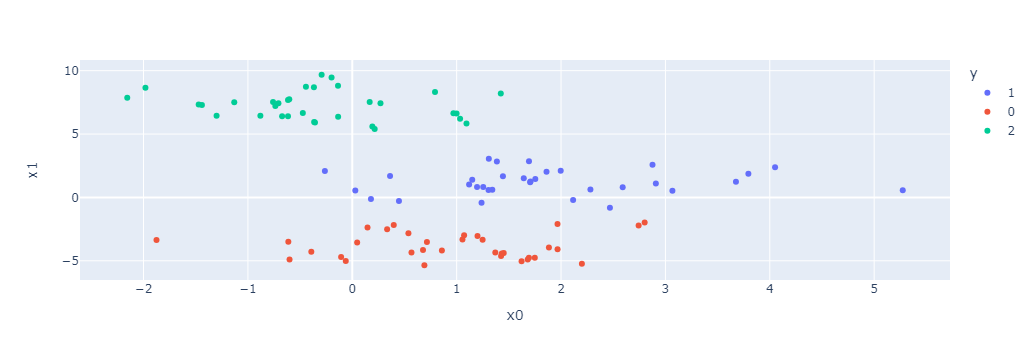

In [4]:
fig = px.scatter(df, x='x0', y='x1', color='y')
fig.show()

## K-means Algorithm 


1. Randomly select a datapoint to initialise as a cluster centroid, up to K times
2. Assign datapoints to its closest centroid (creating a blob)
3. Calculate centroid of your blob
4. Repeat 2-4 until it converges

note: 
- how many clusters do we select? One method is the elbow method, but it's not even recommended by Andrew. Reality is, the choice of clusters is often ambiguous and you'll have to choose based on what makes sense for your business/application. 
- the algorithm may converge into local minimas, which is why we run the randomised initialisation 50-1000 times, then select the ones with the lowest cost

### Assigning Centroids & Randomly Selecting Initial Guess

In [5]:
# vectorised implementation 317 us, approximately 6x faster than loop variant
def rehoming_blobs_v(X, centroids):
    """
    m - # datapoints
    n - # features
    K - # centroids
    
    Inputs: 
    X - vector of size (m,n) of which we're trying to figure out which centroid do they belong to
    centroids - vector of size (K,n)
    
    Output:
    X_rehomed - vector of size (m,1) which indicates which centroid do they belong to
    """
    # first define the number of clusters involved
    K = centroids.shape[0]
    
    """
    PART 1 - calculate norm of X wrt to the first centroid, row-wise. 
        np.linalg.norm( X - centroids[0], axis = 1, keepdims = True )
    OUTPUT: a column vector of the norm of X - Centroid[0]
    
    **  Note, you need to keep the dimension, otherwise it will be flattened into a 1D array. 
    Maintain the vector as a 2D column vector for stacking 
    
    ----
    PART 2 - generator 
        [ part1 for i in range(K) ]
    OUTPUT: K column vectors of the norm of X - Centroid[0:K] 
    
    ----
    PART 3 - horizontal stacking
        np.hstack( part2 )
    OUTPUT: A single m x K matrix 
    
    ----
    PART 4 - calculating the index of which column vector has the shortest distance
        np.argmin(part3, 1)
        
    """
    
    return np.argmin(np.hstack([np.linalg.norm(X - centroids[i], axis = 1, keepdims = True) for i in range(K)]), 1)

In [6]:
# randomly selects K datapoints as 
def initial_guess(df, K):
    rng = np.random.default_rng()
    rand_idx = rng.choice(len(df), size =K, replace = False)
    centroid_guess = df[rand_idx] 
    return centroid_guess
    

In [7]:
# randomly select K datapoints from dataset to become initial centroid guesses
centroid_guess = initial_guess(df.filter(regex='x').values,3)

df['ypred'] = rehoming_blobs_v(df[['x0','x1']].values, centroid_guess)
df['ypred'] = df['ypred'].astype('category')



### archived

In [8]:
# loop version 1.91 ms
def rehoming_blobs_l(X, centroids):
    """
    m - # datapoints
    n - # features
    K - # centroids
    
    Inputs: 
    X - vector of size (m,n) of which we're trying to figure out which centroid do they belong to
    centroids - vector of size (K,n), a bunch of guesses as to where the centroid may be
    
    Output:
    idx - vector of size (m,1) which indicates which centroid do they belong to
    """
    K = centroids.shape[0] # how many clusters
    idx = np.zeros(X.shape[0], dtype=int) # predefining size is faster
    
    # loop through every datapoint
    for i in range(len(X)):
        
        # every datapoint will have a set of K different distances
        dist = []
        for j in range(K):
            dist.append( np.linalg.norm( X[i] - centroids[j] ) )
            
        # select the index of the shortest distance, and store it in idx
        idx[i] = np.argmin(dist)
    return idx

In [9]:
%timeit -n 100 rehoming_blobs_l(df[['x0','x1']].values, centroid_guess)

%timeit -n 100 rehoming_blobs_v(df[['x0','x1']].values, centroid_guess)

1.96 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
316 µs ± 6.99 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Plotting the convergence of centroids

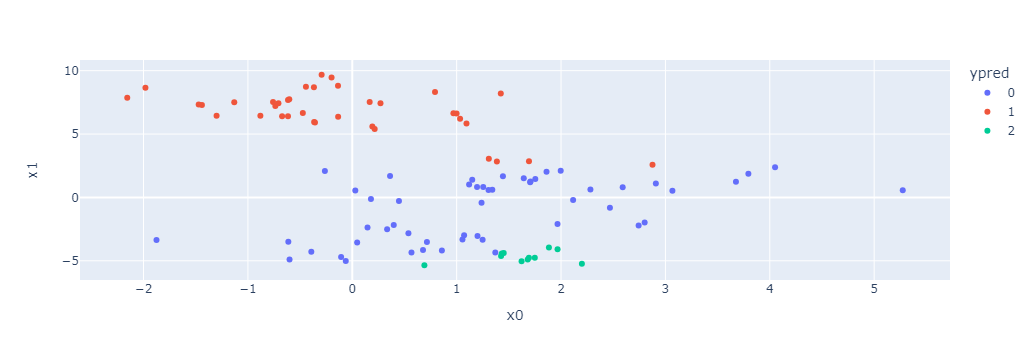

In [10]:
fig = px.scatter(df, x='x0', y='x1', color= 'ypred')
fig.show()

In [11]:
def compute_centroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the 
    data points assigned to each centroid.
    
    Args:
        X (ndarray):   (m, n) Data points
        idx (ndarray): (m,) Array containing index of closest centroid for each 
                       example in X. Concretely, idx[i] contains the index of 
                       the centroid closest to example i
        K (int):       number of centroids
    
    Returns:
        centroids (ndarray): (K, n) New centroids computed
    """
    
    m, n = X.shape
    centroids = np.zeros((K, n))
    
    # for each cluster centroid, we get the centroid by summing column-wise and dividing by the number of datapoints
    for k in range(K):
        centroids[k] = np.sum(X[idx == k], 0)/ len(X[idx == k])
    
    return centroids

In [12]:
idx = df['ypred']
K = 3
X = df.filter(regex='x').values
centroids = compute_centroids(X, idx, K)

print("The centroids are:", centroids)

The centroids are: [[ 1.3033566  -0.97411548]
 [-0.09277181  6.79210542]
 [ 1.61754653 -4.67879181]]


In [13]:
def run_kMeans(X, initial_centroids, max_iters=10):
    """
    Runs the K-Means algorithm on data matrix X, where each row of X
    is a single example
    """
    
    # Initialize values
    m, n = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    centroid_locations = centroids
    idx = np.zeros(m)

    # Run K-Means
    for i in range(max_iters):
        
        #Output progress
        print("K-Means iteration %d/%d" % (i, max_iters-1))
        # For each example in X, assign it to the closest centroid
        idx = rehoming_blobs_v(X, centroids)
            
        # Given the memberships, compute new centroids
        centroids = compute_centroids(X, idx, K)
        centroid_locations = np.vstack((centroid_locations,centroids))
    return centroids, idx, centroid_locations

In [14]:
# centroids, indexes, centroid historical locations
a,b,c = run_kMeans(X, centroid_guess, 10)

# note: centroid locations stacks the centroid at iteration i vertically
# so you need to index it as centroid[blob number :: step = K] 

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9


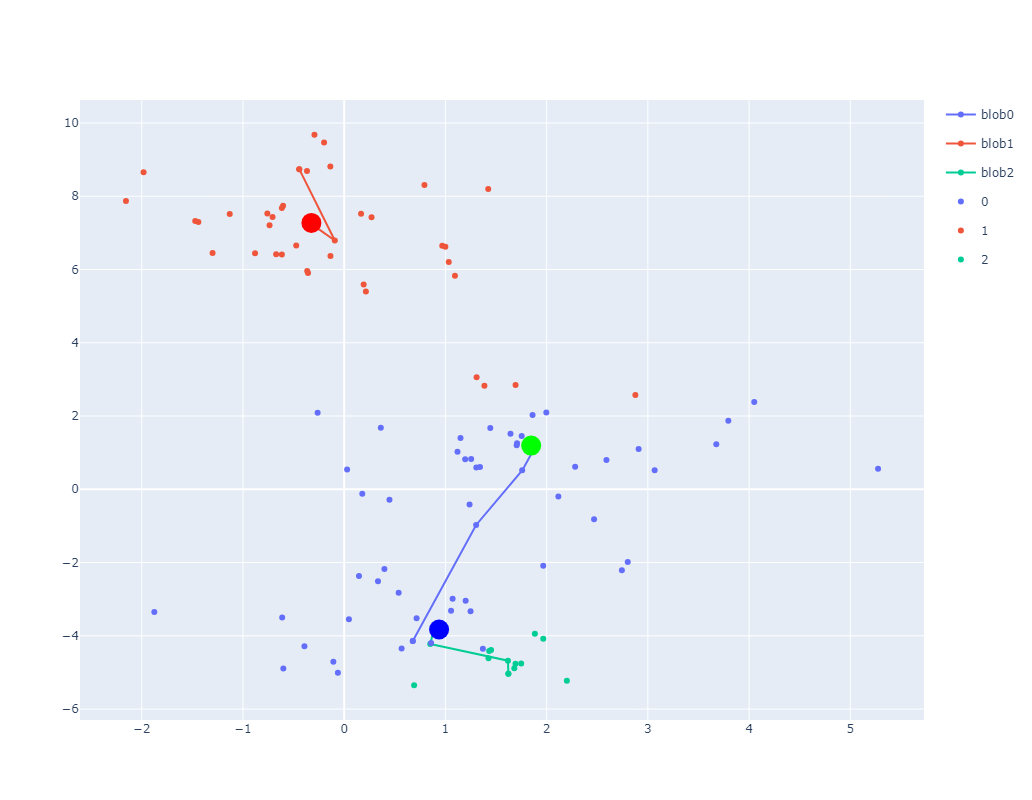

In [15]:
dff = []
for i in range(K):
    dff.append(pd.DataFrame(c[i::3],  columns= ('x' + str(i) for i in range(x.shape[1]))) )
    dff[i]['blob'] = 'blob' + str(i)


dff = pd.concat([df for df in dff]).reset_index()
ffig = px.line(dff, x = 'x0', y ='x1', color = 'blob', markers= True)
tmp = px.scatter(c[-4:-1], x=0, y= 1)

tmp.data[0].marker.color = ['rgb(0,0,255)','rgb(0,255,0)','rgb(255,0,0)']
tmp.data[0].marker.size = 20
tmp


blob = go.Figure(data = ffig.data + fig.data +tmp.data)
blob.update_layout(
    autosize=False,
    width=800,
    height=800
)


## Image Compression with KMeans

### Exploring the image

(128, 128, 3)


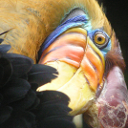

In [16]:
from PIL import Image

img = Image.open('bird_small.png')
print(np.shape(img))
img

In [17]:
img = np.reshape(img, (-1,3) )
img = np.array(img)
img.shape

(16384, 3)

In [18]:
K = 16
centroids, idx, centroid_history = run_kMeans(img, initial_guess(img,K), 10)

rgb_df = pd.DataFrame(img, columns = ['r','g','b'])

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9


In [19]:
def rgb_loop():
    rgb = [] 
    for i in img:
        tmp = 'rgb(' + str(i[0])
        for RGB in i[1:]:
            tmp +=  ','+ str(RGB)
        tmp+=')'
        rgb.append(tmp)
    return rgb

In [20]:
def panda_rgb(df):
    df = df.astype(str)
    return 'rgb(' + df['r'] +','+ df['g']+ ',' +df['b'] + ')'

In [21]:
%timeit -n 10 rgb_loop() 
%timeit -n 10 panda_rgb(rgb_df)
%timeit -n 10 list(map(lambda e:'rgb('+','.join(e.astype(str)) +')', img))

39.4 ms ± 434 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
14.9 ms ± 568 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
58.7 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
fig = px.scatter_3d(rgb_df, x = 'r', y = 'g', z = 'b')
fig.data[0].marker.color =  panda_rgb(rgb_df)
fig.data[0].marker.size = 2
fig.update_layout(height = 1000,width = 900)
fig.show()

In [23]:
centroids = pd.DataFrame(centroids, columns = ['r','g','b'])
centroid_fig = px.scatter_3d(centroids, x='r', y='g', z='b')
centroid_fig.data[0].marker.color =  panda_rgb(centroids)
centroid_fig.data[0].marker.size = 25
centroid_fig.update_layout(height = 1000, width = 900)
centroid_fig.show()

In [24]:
fig.add_trace(centroid_fig.data[0])

In [25]:
import matplotlib.pyplot as plt
def plot_kMeans_RGB(X, centroids, idx, K):
    # Plot the colors and centroids in a 3D space
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(221, projection='3d')
    ax.scatter(*X.T, zdir='z', depthshade=False, s=.3, c=X)
    ax.scatter(*centroids.T, zdir='z', depthshade=False, s=500, c='red', marker='x', lw=3)
    ax.set_xlabel('R value - Redness')
    ax.set_ylabel('G value - Greenness')
    ax.set_zlabel('B value - Blueness')
    ax.w_yaxis.set_pane_color((0., 0., 0., .2))
    ax.set_title("Original colors and their color clusters' centroids")
    plt.show()


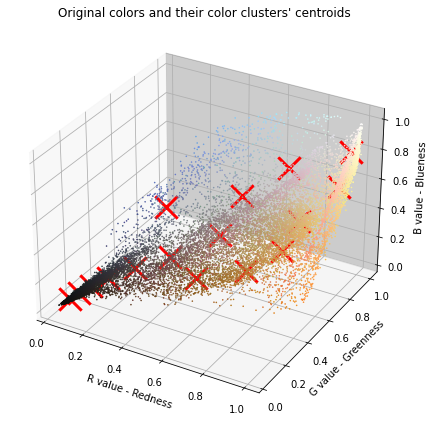

In [26]:
plot_kMeans_RGB(img/255, centroids.values/255, idx, K)

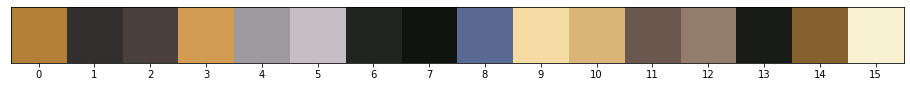

In [27]:
def show_centroid_colors(centroids):
    palette = np.expand_dims(centroids, axis=0)
    num = np.arange(0,len(centroids))
    plt.figure(figsize=(16, 16))
    plt.xticks(num)
    plt.yticks([])
    plt.imshow(palette)
    
show_centroid_colors(centroids.values/255)

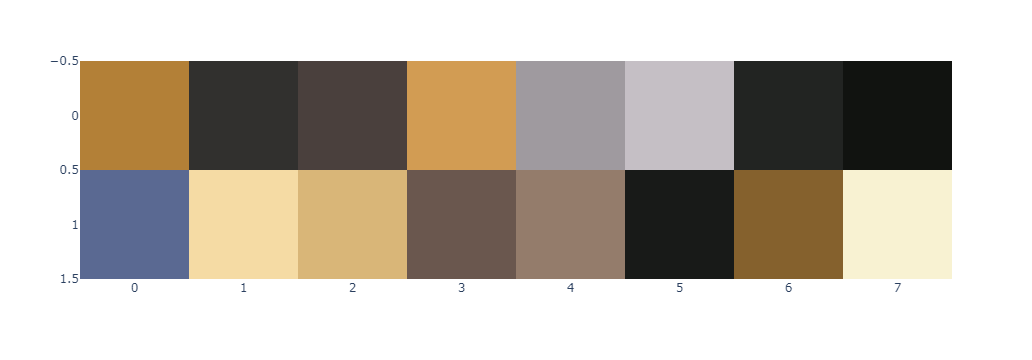

In [28]:
px.imshow(centroids.values.reshape(-1,K//2,3))

In [29]:
idx = rehoming_blobs_v(img, centroids.values)

X_compressed = centroids.values[idx, :]

In [30]:
X_compressed = np.reshape(X_compressed, (-1,128,3))

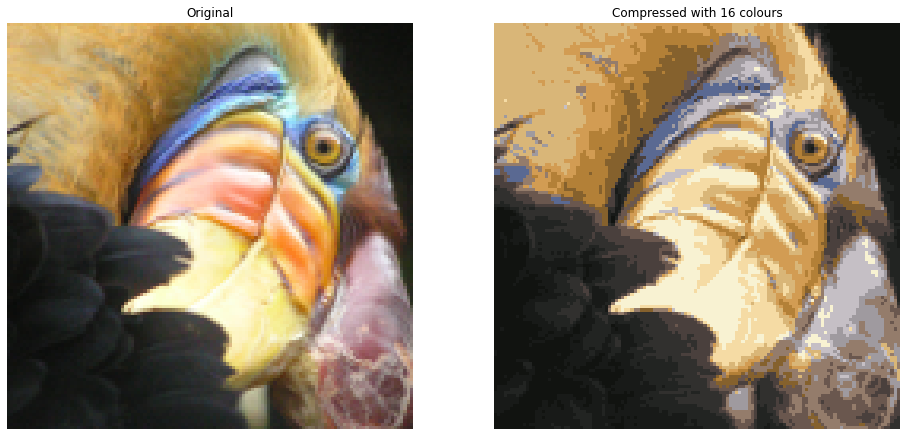

In [31]:
# Display original image
fig, ax = plt.subplots(1,2, figsize=(16,16))
plt.axis('off')

ax[0].imshow(img.reshape((128,-1,3)))
ax[0].set_title('Original')
ax[0].set_axis_off()


# Display compressed image
ax[1].imshow(X_compressed/255)
ax[1].set_title('Compressed with %d colours'%K)
ax[1].set_axis_off()

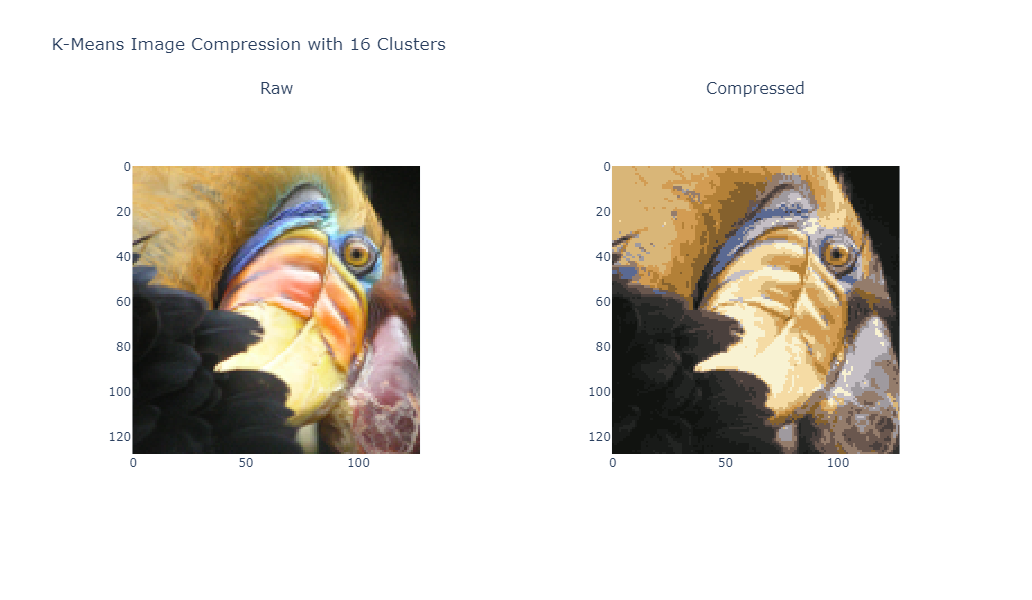

In [32]:
from plotly.subplots import make_subplots

compare_fig = make_subplots(rows=1, cols=2, subplot_titles = ('Raw', 'Compressed'))

compare_fig.add_trace(
    px.imshow(img.reshape((128,-1,3))).data[0],
    row=1, col=1
)

compare_fig.add_trace(
    px.imshow(X_compressed).data[0],
    row=1, col=2
)

compare_fig.update_layout(height=600, width=800, title_text=f"K-Means Image Compression with {K} Clusters")
compare_fig.show()

In [33]:
# personal image

In [34]:
portrait = Image.open('mobile.jpg')
pshape = np.shape(portrait)
print(np.shape(portrait))
portrait = np.reshape(portrait, (-1,3) )
portrait = np.array(portrait)
portrait.shape

(705, 705, 3)


(497025, 3)

In [35]:
K = 48
centroids, idx, centroid_history = run_kMeans(portrait, initial_guess(portrait,K), 10)

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9


In [36]:
rgb_df = pd.DataFrame(portrait, columns = ['r','g','b'])

centroids = pd.DataFrame(centroids, columns = ['r','g','b'])
centroid_fig = px.scatter_3d(centroids, x='r', y='g', z='b')
centroid_fig.data[0].marker.color =  panda_rgb(centroids)
centroid_fig.data[0].marker.size = 15
centroid_fig.update_layout(height = 1000)
centroid_fig.show()

(48, 3)


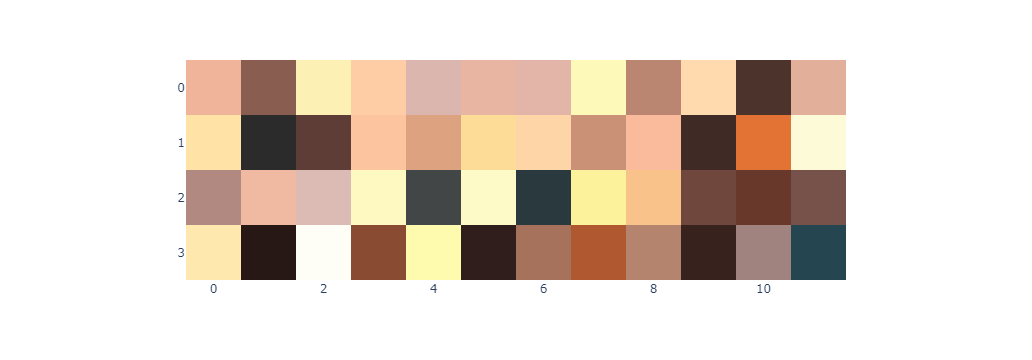

In [37]:
print(centroids.shape)
px.imshow(centroids.values.reshape(4,K//4,3))

In [38]:
idx = rehoming_blobs_v(portrait, centroids.values)

portrait_compressed = centroids.values[idx, :]

portrait_compressed = np.reshape(portrait_compressed, pshape)

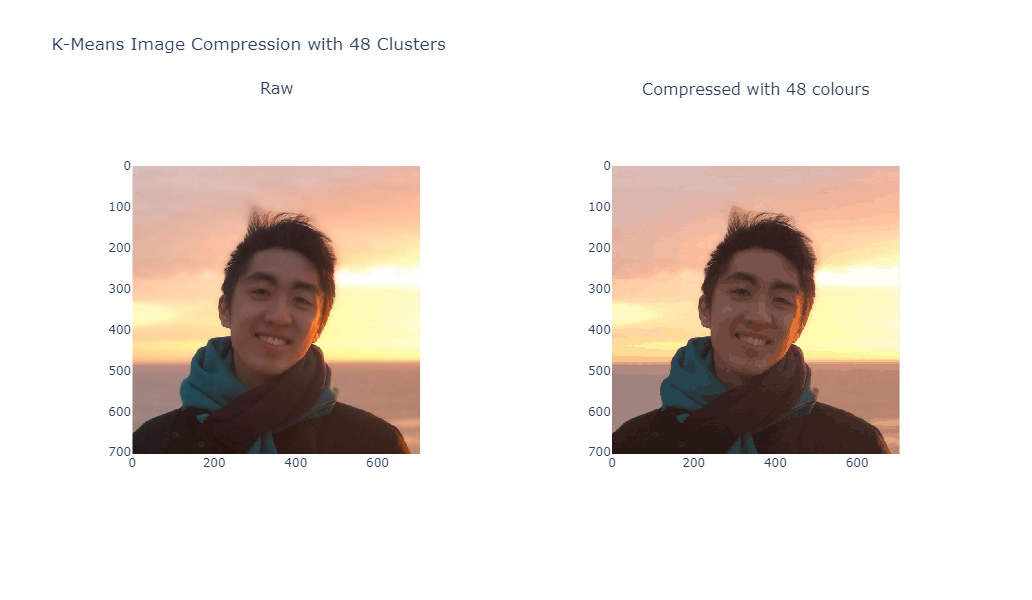

In [39]:
from plotly.subplots import make_subplots

compare_fig = make_subplots(rows=1, cols=2, subplot_titles = ('Raw', f'Compressed with {K} colours'))

compare_fig.add_trace(
    px.imshow(portrait.reshape(pshape)).data[0],
    row=1, col=1
)

compare_fig.add_trace(
    px.imshow(portrait_compressed).data[0],
    row=1, col=2
)

compare_fig.update_layout(height=600, width=800, title_text=f"K-Means Image Compression with {K} Clusters")
compare_fig.show()